
# Convolutional Neural Network CNN
1. Using Glove implementing CNN model
2. Dispaly Confusion Matrix, precision, recall and F1-score
3. Display few prediction using predict module. 
4. Get 10-fold Average of the CNN model.

In [2]:
from __future__ import division, print_function

# dataframe
import pandas as pd

# numpy array
import numpy as np

# figures visualization
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix 
import seaborn as sns

# calc accuracy
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report 

# word2vec
import gensim 
from gensim import models
from gensim.models import Word2Vec 
from gensim.models import KeyedVectors

# CNN model and keras preprocessing
import keras
from keras.callbacks import ModelCheckpoint
from keras.layers import Dense, Dropout, Reshape, Flatten, concatenate, Input, Conv1D, GlobalMaxPooling1D, Embedding, Conv2D, GlobalMaxPooling2D
from keras.models import Sequential
from keras.models import Model
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

# nltk data preprocessing
import nltk
from nltk import word_tokenize
from nltk.tokenize import sent_tokenize 
from nltk.stem import WordNetLemmatizer

# stopword - remove buzz word
from nltk.corpus import stopwords

# splitting data
from sklearn.model_selection import train_test_split

# punctuation - data imbalance
import collections
import re
import string

# File path
import os
import os.path
from os import path

# Translator
import googletrans
from googletrans import Translator

In [3]:
# original english file
filename  = 'Eng-Hin-data/english-anot-shuffled'
orig_df = pd.read_csv(filename + '.csv',  
               delimiter=',')
orig_df.columns = ['Text', 'Label']

In [4]:
# Run only for English data 
orig_df["Text"] = orig_df["Text"].astype(str)
orig_df["Label"] = orig_df["Label"].astype(str)
df = orig_df

In [5]:
df.head

<bound method NDFrame.head of                                                    Text Label
0     '@Cricket_Mann And they will see more of it no...     0
1     "Juma'at Kareem to all my Muslim brother aroun...     1
2     'Thorpe becomes England head coach for Pakista...     0
3     '@ParZevil Plymouth Cricket. THREE transmissions.     0
4     'jungkook didn√¢‚Ç¨‚Ñ¢t get caught eating food duri...     1
...                                                 ...   ...
8433  '@xmufcalisha Looking like a cricket scoreline...     0
8434  'QAnon is a terrorist organisation. Trump is n...     2
8435  'No franchise cricket tournament has a better ...     0
8436  'we are not against every muslim but for that ...     2
8437  'Happy First Muharram √∞≈∏¬•¬≥√∞≈∏≈Ω≈†√∞≈∏≈Ω‚Ä∞  May Allah ...     1

[8438 rows x 2 columns]>

In [6]:
df.Text[6]

"'@SakibulHoque8 @ImranKhanPTI Terrorist is a Muslim.√∞≈∏Àú‚Ç¨"

### Class count

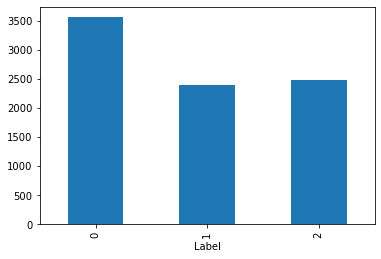

In [7]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(6,4))
df.groupby('Label').Text.count().plot.bar(ylim=0)
plt.show()

In [8]:
# For entire dataset sentences for each labels 
df.Label.value_counts()

0    3555
2    2485
1    2398
Name: Label, dtype: int64

### Balanced Data

In [9]:
#balancing data 
from collections import Counter
import numpy as np
def balanceClasses(xs, ys):
    item = {}
    new_ys = []
    new_xs = []
    #"""Undersample xs, ys to balance classes."""
    freqs = Counter(ys)
    # the most common class  is the maximum number we want for all classes
    max_allowable = (freqs.most_common()[0][1])
    
    for val in freqs.most_common(): # List
        nums = np.random.randint(1000)
        i = 1
        item[val[0]] = max_allowable - val[1]
        
        if item[val[0]] > 0:            
            while(item[val[0]] - i != 0): 
                nums = nums + 1
                if ys[nums] == val[0]:
                    i += 1
                    new_ys.append(ys[nums])
                    new_xs.append(xs[nums])
    return new_xs, new_ys

In [10]:
new_text, new_label = balanceClasses(df['Text'], df['Label'])

In [11]:
data = pd.DataFrame(new_text)
data.columns = ['Text']
data['Label'] = new_label
data = pd.concat([df, data])

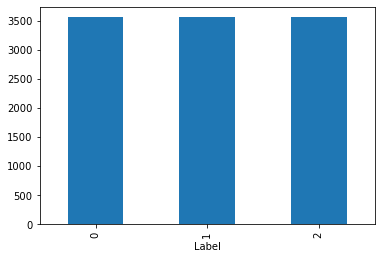

In [12]:
fig1 = plt.figure(figsize=(6,4))
data.groupby('Label').Text.count().plot.bar(ylim=0)
plt.show()

In [13]:
# For entire dataset sentences for each labels 
data.Label.value_counts()

0    3555
2    3554
1    3554
Name: Label, dtype: int64

In [14]:

data=data.sample(frac=1).reset_index(drop=True)
data

Text Label
0      '@ThatKidLouii Subhanallah brother  imma ignor...     1
1                             '@kushumbi0 Happy Muharram     1
2                        'Small back of Phillips over 24     0
3      'Narrated  by Anas: The Prophet said  "None of...     1
4      '#Bangalore #BangloreRiots #BANGALOREburning #...     2
...                                                  ...   ...
10658  '@ESPNcricinfo Follow oru page for cricket mem...     0
10659  'Radical Islamic Bagheads of a feather stick t...     2
10660  '@Lord_Rex2 @sweetysweethrt @_orsteen What wil...     1
10661  'WTF: Biden begs the Muslim radicals for their...     2
10662  '@tradenish @pawan_aflatoon @shuibs @ibusolih ...     2

[10663 rows x 2 columns]

### Data Preprocessing

In [15]:
# People usually join sentences using more than one colon 

def ReplaceDoubleColon(inputString):
    return inputString.replace("..", " ") 

data['Text'] = data['Text'].apply(lambda x: ReplaceDoubleColon(x))

def ReplaceTripleColon(inputString):
    return inputString.replace("...", " ") 

data['Text'] = data['Text'].apply(lambda x: ReplaceTripleColon(x))

def ReplaceFourColon(inputString):
    return inputString.replace("....", " ") 

data['Text'] = data['Text'].apply(lambda x: ReplaceFourColon(x))

In [16]:
def textPattern(text):

    # Clean the text
    text = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", text)
    text = re.sub(r" \n ", " ", text)
    text = re.sub(r"what's", "what is", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", "have", text)
    text = re.sub(r"can't", "can not", text)
    text = re.sub(r"aren't", "are not", text)
    text = re.sub(r"couldn't", "could not", text)
    text = re.sub(r"didn't", "did not", text)
    text = re.sub(r"doesn't", "does not", text)
    text = re.sub(r"don't", "do not", text)
    text = re.sub(r"hadn't", "had not", text)
    text = re.sub(r"hasn't", "has not", text)
    text = re.sub(r"haven't", "have not", text)
    text = re.sub(r"isn't", "is not", text)
    text = re.sub(r"shouldn't", "should not", text)
    text = re.sub(r"wasn't", "was not", text)
    text = re.sub(r"weren't", "were not", text)
    text = re.sub(r"won't", "will not", text)
    text = re.sub(r"wouldn't", "would not", text)
    text = re.sub(r"mustn't", "must not", text)
    text = re.sub(r"i'm", "i am", text)
    text = re.sub(r"\'re", "are", text)
    text = re.sub(r",", " ", text)
    text = re.sub(r"\.", " ", text)
    text = re.sub(r"!", " ", text)
    text = re.sub(r"\/", " ", text)
    text = re.sub(r"\^", " ^ ", text)
    text = re.sub(r"\+", " ", text)
    text = re.sub(r"\-", " - ", text)
    text = re.sub(r"\= =", " ", text)
    text = re.sub(r"\==", " ", text)
    text = re.sub(r"'", " ", text)
    text = re.sub(r"(\d+)(k)", r"\g<1>000", text)
    text = re.sub(r":", " : ", text)
    text = re.sub(r"\0s", "0", text)
    text = re.sub(r" 9 11 ", "911", text)
    text = re.sub(r"\s{2,}", " ", text)
    return text

data['Text'] = data['Text'].apply(lambda x: textPattern(x))

In [17]:
data.shape

(10663, 2)

In [18]:
# Word Tokenization
tokens = [word_tokenize(sen) for sen in data.Text]

In [19]:
# Lower Case
def lower_token(tokens): 
    return [w.lower() for w in tokens]    
    
lower_tokens = [lower_token(token) for token in tokens]

In [20]:
# Remove Link

def removeLink(token):
    word = []
    for w in token:
        if not w.startswith('http'):
            word.append(w)
    return word 
    
removedLink_tokens = [removeLink(token) for token in lower_tokens]

In [21]:
# Word Lemmatization
def lemmatization(token):
    return [lemmatizer.lemmatize(w) for w in token] 

lemmatizer = WordNetLemmatizer()

lemmatized_tokens = [lemmatization(token) for token in removedLink_tokens]

In [22]:
# Removing Stopwords
stoplist = stopwords.words('english')

In [23]:
def removeStopWords(tokens): 
    return [word for word in tokens if word not in stoplist]

filtered_words = [removeStopWords(sen) for sen in lemmatized_tokens]
data['Text_Final'] = [' '.join(sen) for sen in filtered_words]
data['tokens'] = filtered_words

In [24]:
zero  = []
one = []
two = []
for l in data.Label:
    
    if l == '0':
        zero.append(1)
        one.append(0)
        two.append(0)
    elif l == '1':
        zero.append(0)
        one.append(1)
        two.append(0)
    elif l == '2':
        zero.append(0)
        one.append(0)
        two.append(1)
        
data['0']= zero
data['1']= one
data['2']= two

data = data[['Text_Final', 'tokens', 'Label', '0', '1', '2']]

In [25]:
category_id = []
for l in data.Label:
    
    if l == '0':
        category_id.append('0')
    elif l == '1':
        category_id.append('1')
    elif l == '2':
        category_id.append('2')
        
data['Category_id'] = category_id

data = data[['Text_Final', 'tokens', 'Label', '0', '1', '2', 'Category_id' ]]
data.head(9)

Text_Final  \
0  thatkidlouii subhanallah brother imma ignore t...   
1                           kushumbi0 happy muharram   
2                             small back phillips 24   
3  narrated ana : prophet said none faith till wi...   
4  bangalore bangloreriots bangaloreburning fucki...   
5  cjwerleman stop islamic terrorism ask somethin...   
6                    happy muharram islamic new year   
7  warisha64022312 mkatju kanhaiyakumar shehla ra...   
8           happy islamic new year 1 muharram 1442 h   

                                              tokens Label  0  1  2  \
0  [thatkidlouii, subhanallah, brother, imma, ign...     1  0  1  0   
1                       [kushumbi0, happy, muharram]     1  0  1  0   
2                        [small, back, phillips, 24]     0  1  0  0   
3  [narrated, ana, :, prophet, said, none, faith,...     1  0  1  0   
4  [bangalore, bangloreriots, bangaloreburning, f...     2  0  0  1   
5  [cjwerleman, stop, islamic, terrorism, ask, so...     2  0  0  1   
6              [happy, muharram, islamic, new, year]     1  0  1  0   
7  [warisha64022312, mkatju, kanhaiyakumar, shehl...     2  0  0  1   
8  [happy, islamic, new, year, 1, muharram, 1442, h]     1  0  1  0   

  Category_id  
0           1  
1           1  
2           0  
3           1  
4           2  
5           2  
6           1  
7           2  
8           1

In [26]:
from io import StringIO
category_id_df = data[['Label', 'Category_id']].drop_duplicates().sort_values('Category_id')
category_to_label_dict = dict(category_id_df.values)
label_to_category_dict = dict(category_id_df[['Category_id', 'Label']].values)

#### Split Data into test and train
We will use 90 % data for training and 20 % for testing. We use random state so every time we get the same training and testing data.

In [27]:
data.shape

(10663, 7)

In [28]:
data_train, data_test = train_test_split(data, test_size=0.10, random_state=42)


In [29]:
# # total training words
totalTrainingWords = [word for tokens in data_train["tokens"] for word in tokens]

# # Storing Length of the training sentence
lengthTrainingSentences = [len(tokens) for tokens in data_train["tokens"]]

# # training Vocabulary size
trainingVocabSize = sorted(list(set(totalTrainingWords)))

## Total number of lines
linesCount = len(data_train["tokens"])

### Load Google News Glove model

In [30]:
# word2vec_path = 'GoogleNews-vectors-negative300.bin'
# #word2vec_path = 'glove.6B.50d.word2vec'

In [31]:
# from gensim import models
# word2vec = models.KeyedVectors.load_word2vec_format(word2vec_path, binary=True)


In [32]:
# Convert Glove file to word2vec format (examples: uses 50 dimensions since it's faster)
from gensim.scripts.glove2word2vec import glove2word2vec
glove_input_file = 'glove.6B.300d.txt'  # I unzipped in glove.6B subdirectory 
word2vec_output_file = 'glove.6B.300d.word2vec'
glove2word2vec(glove_input_file, word2vec_output_file)

(400000, 300)

In [33]:
# Use the converted Glove file


filename = 'glove.6B.300d.word2vec'
word2vec = KeyedVectors.load_word2vec_format(filename, binary=False)


In [34]:
word2vec

In [35]:
MAX_SEQUENCE_LENGTH = 150
EMBEDDING_DIM = 300


### Tokenize and Pad sequences

In [36]:
tokenizer = Tokenizer(num_words=len(trainingVocabSize), lower=True, char_level=False)
tokenizer.fit_on_texts(data_train["Text_Final"].tolist())
training_sequences = tokenizer.texts_to_sequences(data_train["Text_Final"].tolist())

train_word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(train_word_index))

Found 15589 unique tokens.


In [37]:
cnnTrainData = pad_sequences(training_sequences, maxlen=MAX_SEQUENCE_LENGTH)

In [38]:
train_embedding_weights = np.zeros((len(train_word_index)+1, EMBEDDING_DIM))
for word,index in train_word_index.items():
    train_embedding_weights[index,:] = word2vec[word] if word in word2vec else np.random.rand(EMBEDDING_DIM)
print(train_embedding_weights.shape)

(15590, 300)


In [39]:
test_sequences = tokenizer.texts_to_sequences(data_test["Text_Final"].tolist())
cnnTestData = pad_sequences(test_sequences, maxlen= MAX_SEQUENCE_LENGTH)

### Define CNN

The model is from the paper 'Convolutional Neural Networks for Sentence Classification' we have updated the network according to our requirement [1]

In [40]:
label_names = ['0', '1', '2']

In [41]:
def ConvolutionalNeuralNet(embeddings, max_sequence_length, num_words, embedding_dim, labels_index):
    
    # Embedding layer
    embedding_layer = Embedding(num_words,
                            embedding_dim,
                            weights=[embeddings],
                            input_length=max_sequence_length,
                            trainable=False)
    
    sequence_input = Input(shape=(max_sequence_length,), dtype='int32')
    embedded_sequences = embedding_layer(sequence_input)

    convs = []
    
    #Kernal (window) size
    filter_sizes = [2,3,4,5]

    # Convolution Layer and max-pooling
    for filter_size in filter_sizes:
        l_conv = Conv1D(filters=512, kernel_size=filter_size, activation='relu')(embedded_sequences)
        l_pool = GlobalMaxPooling1D()(l_conv)
        convs.append(l_pool)
        
    l_merge = concatenate(convs, axis=1)
    
    # softmax layer for multiclass identification 
    x = Dropout(0.1)(l_merge)  
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.2)(x)
    preds = Dense(labels_index, activation='softmax')(x)

    model = Model(sequence_input, preds)
    model.compile(loss= 'categorical_crossentropy',
                 optimizer = keras.optimizers.RMSprop(learning_rate=1e-3),
#                    optimizer='adam',
                  metrics=['accuracy'])
    return model

In [42]:
# Splitting train data into X_train and y_train
y_train = data_train[label_names].values
x_train = cnnTrainData
y_tr = y_train

In [43]:
# Splitting train data into X_test and y_test
y_test = data_test[label_names].values
x_test = cnnTestData
y_tst = y_test

In [44]:
model = ConvolutionalNeuralNet(train_embedding_weights, MAX_SEQUENCE_LENGTH, len(train_word_index)+1, EMBEDDING_DIM, len(list(label_names)))

In [45]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 150, 300)     4677000     input_1[0][0]                    
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 149, 512)     307712      embedding[0][0]                  
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 148, 512)     461312      embedding[0][0]                  
______________________________________________________________________________________________

### Train CNN

In [46]:
num_epochs = 10
batch_size = 512

In [47]:
history = model.fit(x_train, y_tr, epochs=num_epochs, validation_split=0.1, shuffle=True, batch_size=batch_size)

Epoch 1/10
17/17 [==============================] - 43s 3s/step - loss: 2.5318 - accuracy: 0.7495 - val_loss: 0.3251 - val_accuracy: 0.8813
Epoch 2/10
17/17 [==============================] - 41s 2s/step - loss: 0.2071 - accuracy: 0.9311 - val_loss: 0.2162 - val_accuracy: 0.9281
Epoch 3/10
17/17 [==============================] - 41s 2s/step - loss: 0.1874 - accuracy: 0.9338 - val_loss: 0.1893 - val_accuracy: 0.9396
Epoch 4/10
17/17 [==============================] - 41s 2s/step - loss: 0.1213 - accuracy: 0.9601 - val_loss: 0.1745 - val_accuracy: 0.9406
Epoch 5/10
17/17 [==============================] - 41s 2s/step - loss: 0.1273 - accuracy: 0.9602 - val_loss: 0.1608 - val_accuracy: 0.9510
Epoch 6/10
17/17 [==============================] - 41s 2s/step - loss: 0.1018 - accuracy: 0.9689 - val_loss: 0.1610 - val_accuracy: 0.9552
Epoch 7/10
17/17 [==============================] - 41s 2s/step - loss: 0.0499 - accuracy: 0.9849 - val_loss: 0.1507 - val_accuracy: 0.9531
Epoch 8/10
17/17 [==

In [48]:
# evaluate on test data
results = model.evaluate(x_test, y_tst)

34/34 [==============================] - 2s 61ms/step - loss: 0.1165 - accuracy: 0.9728


In [49]:
# predict model
predictions = model.predict(cnnTestData, batch_size=1024, verbose=1)

2/2 [==============================] - 0s 40ms/step


### Testing few sentences using our model

In [50]:

labels = ['0', '1', '2']

def makeprediction(texts):
    tk = Tokenizer()
    tk.fit_on_texts(texts)
    index_list = tk.texts_to_sequences(texts)
    x_train = pad_sequences(index_list, maxlen=150)
    pred = model.predict(x_train)
    result = labels[np.argmax(pred)]
    return result

In [51]:
prediction_labels=[]
for p in predictions:
    prediction_labels.append(labels[np.argmax(p)])

In [52]:
sum(data_test.Label==prediction_labels)/len(prediction_labels)

0.9728209934395501

In [53]:
data_test.Label.value_counts()

1    365
0    352
2    350
Name: Label, dtype: int64

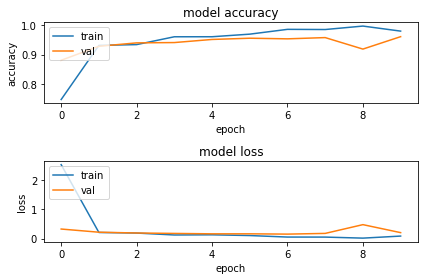

In [54]:
plt.figure(1)
# summarize history for accuracy
plt.subplot(211)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
# summarize history for loss
plt.subplot(212)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.tight_layout()
plt.show()

In [55]:
results = confusion_matrix(data_test.Label, prediction_labels)
print ('Confusion Matrix :')
print(results) 
print ('Accuracy Score :',accuracy_score(data_test.Label, prediction_labels))
print ('Report : ')
print (classification_report(data_test.Label, prediction_labels))

Confusion Matrix :
[[346   1   5]
 [  2 358   5]
 [  7   9 334]]
Accuracy Score : 0.9728209934395501
Report : 
              precision    recall  f1-score   support

           0       0.97      0.98      0.98       352
           1       0.97      0.98      0.98       365
           2       0.97      0.95      0.96       350

    accuracy                           0.97      1067
   macro avg       0.97      0.97      0.97      1067
weighted avg       0.97      0.97      0.97      1067



                        Convolution Neural Network


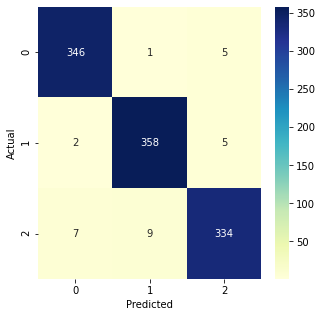

In [56]:
from sklearn.metrics import confusion_matrix
print("                        Convolution Neural Network")
conf_mat = confusion_matrix(data_test.Label, prediction_labels)
fig, ax = plt.subplots(figsize=(5,5))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap ='YlGnBu',
            xticklabels=category_id_df.Label.values, yticklabels=category_id_df.Label.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

### Testing CNN using KFold cross validation

In [57]:
from sklearn.model_selection import StratifiedKFold
from scipy.stats import zscore
from sklearn import metrics
import tensorflow as tf
import random

f_score=[]
fold = 10
label_names = ['0', '1', '2']
num_epochs = 5
batch_size = 32
#oos_y = []
#oos_pred = []
results = []
#for train, test in kf.split(data["tokens"], data['Label']):

for i in range(fold):
    print("Fold: ", i+1)
    random_num = np.random.randint(1,7000, 1)[0]
    data_train, data_test = train_test_split(data, test_size=0.10, shuffle = True, random_state = random_num)

    # # total training words
    totalTrainingWords = [word for tokens in data_train["tokens"] for word in tokens]

    # # Storing Length of the training sentence
    lengthTrainingSentences = [len(tokens) for tokens in data_train["tokens"]]

    # # training Vocabulary size
    trainingVocabSize = sorted(list(set(totalTrainingWords)))

    ## Total number of lines
    linesCount = len(data_train["tokens"])
    
    tokenizer = Tokenizer(num_words=len(trainingVocabSize), lower=True, char_level=False)
    tokenizer.fit_on_texts(data_train["Text_Final"].tolist())
    training_sequences = tokenizer.texts_to_sequences(data_train["Text_Final"].tolist())

    train_word_index = tokenizer.word_index
    cnnTrainData = pad_sequences(training_sequences, maxlen=MAX_SEQUENCE_LENGTH)
    
    train_embedding_weights = np.zeros((len(train_word_index)+1, EMBEDDING_DIM))
    
    for word,index in train_word_index.items():
        train_embedding_weights[index,:] = word2vec[word] if word in word2vec else np.random.rand(EMBEDDING_DIM)
        
    test_sequences = tokenizer.texts_to_sequences(data_test["Text_Final"].tolist())
    cnnTestData = pad_sequences(test_sequences, maxlen= MAX_SEQUENCE_LENGTH)
    
    # Splitting train data into X_train and y_train
    y_train = data_train[label_names].values
    x_train = cnnTrainData
    y_tr = y_train
    
    # Splitting train data into X_test and y_test
    y_test = data_test[label_names].values
    x_test = cnnTestData
    y_tst = y_test
    
    # create model
    model = ConvolutionalNeuralNet(train_embedding_weights, MAX_SEQUENCE_LENGTH, len(train_word_index)+1, EMBEDDING_DIM, len(list(label_names)))
    
    #Train Model
    history = model.fit(x_train, y_tr, epochs=num_epochs, validation_split=0.1, shuffle=True, batch_size=batch_size)
      
    # model evaluate
    
    print("Results for current fold:")
    results.append(model.evaluate(x_test, y_tst, batch_size=128))

#     predictions = model.predict(cnnTestData, batch_size=1024, verbose=0)
#     oos_y.append(y_test)
#     oos_pred.append(predictions)
    
    #score = np.sqrt(metrics.mean_squared_error(predictions, y_test))
#    f_score.append(count)

model.save('model_CNN.h5')    

Fold:  1
Epoch 1/5
270/270 [==============================] - 51s 190ms/step - loss: 0.4225 - accuracy: 0.9005 - val_loss: 0.1475 - val_accuracy: 0.9563
Epoch 2/5
270/270 [==============================] - 51s 189ms/step - loss: 0.1461 - accuracy: 0.9599 - val_loss: 0.1422 - val_accuracy: 0.9604
Epoch 3/5
270/270 [==============================] - 51s 189ms/step - loss: 0.0974 - accuracy: 0.9792 - val_loss: 0.1718 - val_accuracy: 0.9594
Epoch 4/5
270/270 [==============================] - 51s 189ms/step - loss: 0.0627 - accuracy: 0.9875 - val_loss: 0.3322 - val_accuracy: 0.9604
Epoch 5/5
270/270 [==============================] - 51s 189ms/step - loss: 0.0778 - accuracy: 0.9869 - val_loss: 0.3014 - val_accuracy: 0.9667
Results for current fold:
9/9 [==============================] - 2s 186ms/step - loss: 0.3328 - accuracy: 0.9653
Fold:  2
Epoch 1/5
270/270 [==============================] - 51s 189ms/step - loss: 0.3903 - accuracy: 0.9019 - val_loss: 0.3609 - val_accuracy: 0.8938
Epoch

In [58]:
import statistics 
# for i in range(len(results)):
#     print("Fold: ", i+1)
#     print("test loss, test acc:", results[i])

score = []
for i in results:
    score.append(i[1])
x = statistics.mean(score)
    
print("Kfold Mean: ", x)

Kfold Mean:  0.9596063613891601


In [63]:
translator = Translator()

In [64]:
# 1
hin_text =  "‡§á‡§∏‡§≤‡§æ‡§Æ ‡§∏‡•Å‡§Ç‡§¶‡§∞ ‡§π‡•à"
print("Hindi: ", hin_text)

trans = translator.translate(hin_text, dest='en')
print('Translated:', trans.text)
texts = [trans.text]
print('Predicted Label: ',makeprediction(texts))

Hindi:  ‡§á‡§∏‡§≤‡§æ‡§Æ ‡§∏‡•Å‡§Ç‡§¶‡§∞ ‡§π‡•à
Translated: Islam is beautiful
Predicted Label:  0


In [65]:
# 0
hin_text =  " ‡§∏‡§Æ‡§æ‡§ú ‡§µ‡§æ‡§¶‡•Ä  ‡§™‡§æ‡§∞‡•ç‡§ü‡•Ä ‡§ú‡§ø‡§Ç‡§¶‡§æ‡§¨‡§æ‡§¶ "
print("Hindi: ", hin_text)

trans = translator.translate(hin_text, dest='en')
print('Translated:', trans.text)
texts = [trans.text]
print('Predicted Label: ',makeprediction(texts))

Hindi:   ‡§∏‡§Æ‡§æ‡§ú ‡§µ‡§æ‡§¶‡•Ä  ‡§™‡§æ‡§∞‡•ç‡§ü‡•Ä ‡§ú‡§ø‡§Ç‡§¶‡§æ‡§¨‡§æ‡§¶ 
Translated: Samajwadi Party Zindabad
Predicted Label:  0


In [70]:
# 2
hin_text =  "'‡§ó‡§æ‡§ú‡§æ ‡§Æ‡•á‡§Ç ‡§¶‡•Ä‡§µ‡§æ‡§≤‡•Ä ‡§ï‡•Ä ‡§¢‡•á‡§∞‡•ã ‡§¨‡§ß‡§æ‡§à ‡§Æ‡§ø‡§§‡•ç‡§∞‡•ã üòäüíê  #IsraeliBombing üòÇüòÇ"
print("Hindi: ", hin_text)

trans = translator.translate(hin_text, dest='en')
print('Translated:', trans.text)
texts = [trans.text]
print('Predicted Label: ',makeprediction(texts))

Hindi:  '‡§ó‡§æ‡§ú‡§æ ‡§Æ‡•á‡§Ç ‡§¶‡•Ä‡§µ‡§æ‡§≤‡•Ä ‡§ï‡•Ä ‡§¢‡•á‡§∞‡•ã ‡§¨‡§ß‡§æ‡§à ‡§Æ‡§ø‡§§‡•ç‡§∞‡•ã üòäüíê  #IsraeliBombing üòÇüòÇ
Translated: 'Happy Diwali greetings in Gaza Friends üòäüíê #IsraeliBombing üòÇüòÇ
Predicted Label:  1


In [67]:
# 0
texts = ["@'England look to clinch Pakistan test series before step into unknown"]
print(makeprediction(texts))

1


In [69]:
# 0
texts = ["''In what hopscotch? Cricket?"]
print(makeprediction(texts))

0


In [62]:
# 1
texts = ["My tl is filled with Shia-Sunni controversy. I should've deactivated before Moharram started."]
print(makeprediction(texts))

1


### Reference
[1] "Convolutional Neural Networks for Sentence Classification" by Yoon Kim
